<a href="https://colab.research.google.com/github/Ace-Arvy/Ace-Arvy/blob/main/Recipe_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install kaggle --quiet
!pip install surprise --quiet  # Collaborative filtering
!pip install nltk --quiet  # NLP processing

# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import os

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

print("Environment ready!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Environment ready!


In [8]:
# Upload CSV files
from google.colab import files

print("Upload interactions_train.csv, interactions_validation.csv, interactions_test.csv")
print("Also upload PP_recipes.csv and PP_users.csv")
uploaded = files.upload()

# Load interactions datasets
interactions_train = pd.read_csv("interactions_train.csv")
interactions_validation = pd.read_csv("interactions_validation.csv")
interactions_test = pd.read_csv("interactions_test.csv")

# Load preprocessed metadata
pp_recipes = pd.read_csv("PP_recipes.csv")
pp_users = pd.read_csv("PP_users.csv")

# Convert to pickle
interactions_train.to_pickle("data/interactions_train.pkl")
interactions_validation.to_pickle("data/interactions_validation.pkl")
interactions_test.to_pickle("data/interactions_test.pkl")
pp_recipes.to_pickle("data/PP_recipes.pkl")
pp_users.to_pickle("data/PP_users.pkl")

print("Conversion to pickle format complete!")

Upload interactions_train.csv, interactions_validation.csv, interactions_test.csv
Also upload PP_recipes.csv and PP_users.csv


Saving interactions_train.csv to interactions_train.csv
Saving interactions_test.csv to interactions_test.csv
Saving interactions_validation.csv to interactions_validation.csv
Saving PP_recipes.csv to PP_recipes.csv
Saving PP_users.csv to PP_users.csv


OSError: Cannot save file into a non-existent directory: 'data'

In [9]:
import os

if not os.path.exists("data"):
    os.makedirs("data")  # Create the 'data' directory

print("Setup complete. Directory 'data' created if it didn't exist.")

Setup complete. Directory 'data' created if it didn't exist.


In [10]:
# Convert to pickle
interactions_train.to_pickle("data/interactions_train.pkl")
interactions_validation.to_pickle("data/interactions_validation.pkl")
interactions_test.to_pickle("data/interactions_test.pkl")
pp_recipes.to_pickle("data/PP_recipes.pkl")
pp_users.to_pickle("data/PP_users.pkl")

print("Conversion to pickle format complete!")

Conversion to pickle format complete!


In [11]:
# Load datasets from pickle
interactions_train = pd.read_pickle("data/interactions_train.pkl")
pp_recipes = pd.read_pickle("data/PP_recipes.pkl")

# Merge interactions with recipes
train_data = interactions_train.merge(pp_recipes, left_on="recipe_id", right_on="id", how="inner")

# Check the combined dataset
print("Combined Dataset Shape:", train_data.shape)
print(train_data.head())

Combined Dataset Shape: (698901, 14)
   user_id  recipe_id        date  rating      u     i_x    id     i_y  \
0     2046       4684  2000-02-25     5.0  22095   44367  4684   44367   
1     2046        517  2000-02-25     5.0  22095   87844   517   87844   
2     1773       7435  2000-03-13     5.0  24732  138181  7435  138181   
3     1773        278  2000-03-13     4.0  24732   93054   278   93054   
4     2046       3431  2000-04-07     5.0  22095  101723  3431  101723   

                                         name_tokens  \
0  [40480, 17364, 11892, 556, 14721, 955, 644, 81...   
1                  [40480, 9319, 6003, 35045, 40481]   
2  [40480, 5434, 252, 1432, 1055, 730, 11434, 40481]   
3                 [40480, 9319, 34058, 35135, 40481]   
4  [40480, 552, 2931, 16954, 10666, 6821, 6856, 4...   

                                   ingredient_tokens  \
0  [[17364, 21170], [4017], [955, 644, 818, 955, ...   
1  [[16212], [21601], [6812], [5940], [2279, 2591...   
2  [[19414], 

In [15]:
# Inspect columns of the dataset
print("Columns in the interactions_train dataset:")
print(interactions_train.columns)

print("\nColumns in the PP_recipes dataset:")
print(pp_recipes.columns)

Columns in the interactions_train dataset:
Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i'], dtype='object')

Columns in the PP_recipes dataset:
Index(['id', 'i', 'name_tokens', 'ingredient_tokens', 'steps_tokens',
       'techniques', 'calorie_level', 'ingredient_ids'],
      dtype='object')


In [16]:
# Merge interactions with recipes based on recipe_id (interactions_train) and id (PP_recipes)
train_data = interactions_train.merge(pp_recipes, left_on="recipe_id", right_on="id", how="inner")

# Inspect the merged dataset
print("Merged Dataset Columns:")
print(train_data.columns)

print("\nSample Data:")
print(train_data.head())

Merged Dataset Columns:
Index(['user_id', 'recipe_id', 'date', 'rating', 'u', 'i_x', 'id', 'i_y',
       'name_tokens', 'ingredient_tokens', 'steps_tokens', 'techniques',
       'calorie_level', 'ingredient_ids'],
      dtype='object')

Sample Data:
   user_id  recipe_id        date  rating      u     i_x    id     i_y  \
0     2046       4684  2000-02-25     5.0  22095   44367  4684   44367   
1     2046        517  2000-02-25     5.0  22095   87844   517   87844   
2     1773       7435  2000-03-13     5.0  24732  138181  7435  138181   
3     1773        278  2000-03-13     4.0  24732   93054   278   93054   
4     2046       3431  2000-04-07     5.0  22095  101723  3431  101723   

                                         name_tokens  \
0  [40480, 17364, 11892, 556, 14721, 955, 644, 81...   
1                  [40480, 9319, 6003, 35045, 40481]   
2  [40480, 5434, 252, 1432, 1055, 730, 11434, 40481]   
3                 [40480, 9319, 34058, 35135, 40481]   
4  [40480, 552, 2931, 169

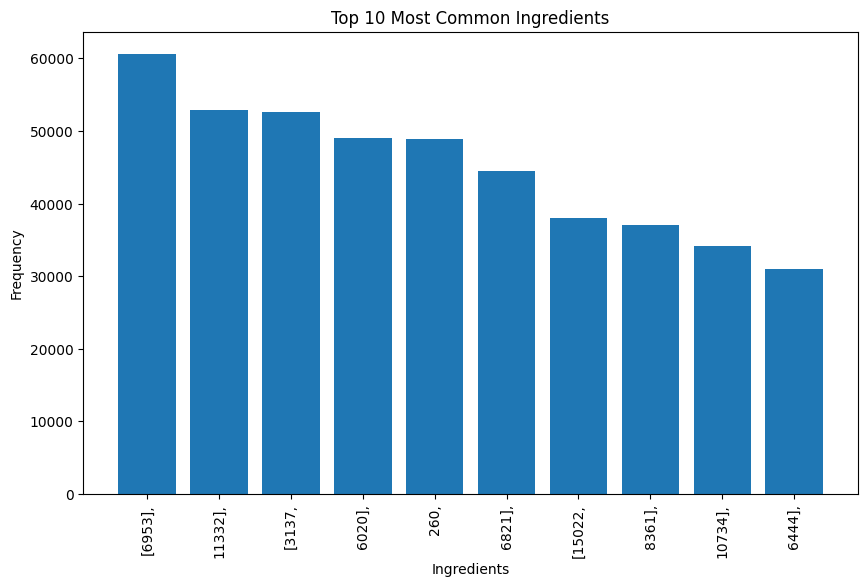

In [67]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract ingredients from the 'ingredient_tokens' column
all_ingredients = []

# Flatten the list of ingredients from the 'ingredient_tokens' column
for recipe in pp_recipes['ingredient_tokens']:
    # Ensure the value is a list (could be a string or list, so check and process)
    if isinstance(recipe, list):
        all_ingredients.extend(recipe)
    else:
        # If it's a string, split by spaces
        all_ingredients.extend(recipe.split())

# Get frequency distribution of ingredients
ingredient_freq = Counter(all_ingredients)

# Get the top 10 most common ingredients
top_ingredients = ingredient_freq.most_common(10)
ingredients, counts = zip(*top_ingredients)

# Plot the result
plt.figure(figsize=(10,6))
plt.bar(ingredients, counts)
plt.xticks(rotation=90)
plt.title("Top 10 Most Common Ingredients")
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.show()

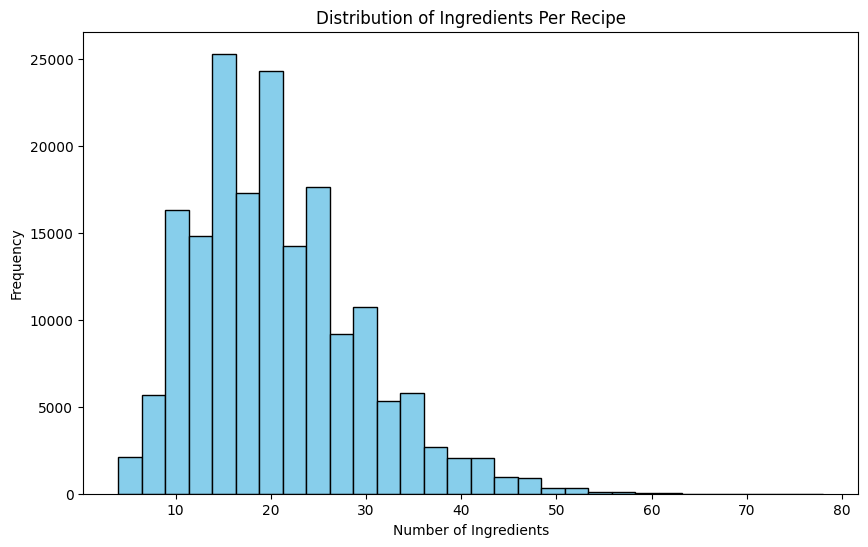

In [55]:

# Calculate the number of ingredients for each recipe
recipe_lengths = pp_recipes['ingredient_tokens'].apply(lambda x: len(x) if isinstance(x, list) else len(x.split()))

# Plot the distribution of recipe lengths (number of ingredients per recipe)
plt.figure(figsize=(10, 6))
plt.hist(recipe_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Ingredients Per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

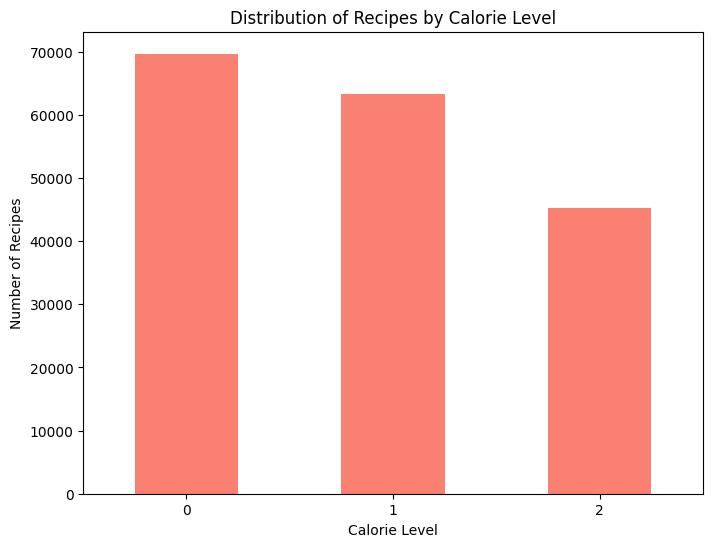

In [61]:
# Check if 'calorie_level' is categorical and count the occurrences
calorie_distribution = pp_recipes['calorie_level'].value_counts()

# Plot the distribution of calorie levels
plt.figure(figsize=(8, 6))
calorie_distribution.plot(kind='bar', color='salmon')
plt.title('Distribution of Recipes by Calorie Level')
plt.xlabel('Calorie Level')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=0)
plt.show()

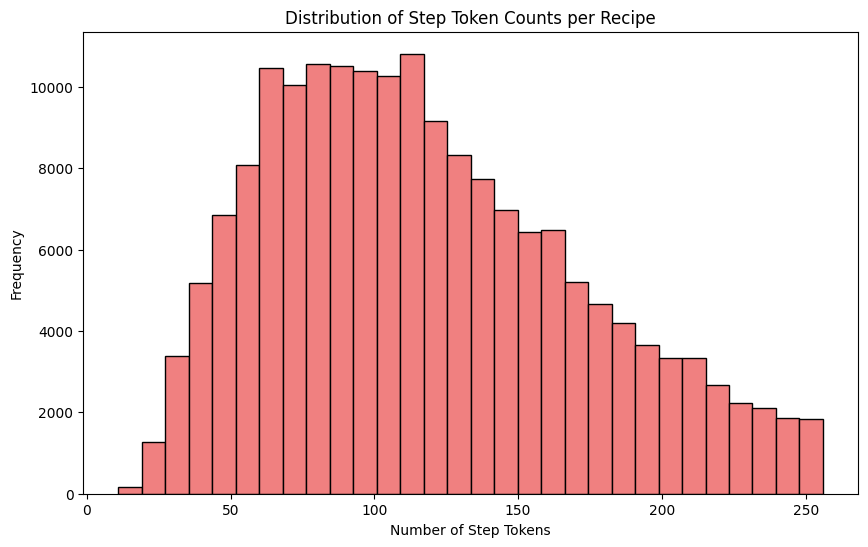

In [60]:
# Calculate the number of tokens (words) in the 'steps_tokens' column
steps_token_counts = pp_recipes['steps_tokens'].apply(lambda x: len(x) if isinstance(x, list) else len(x.split()))

# Plot the distribution of the number of tokens in steps
plt.figure(figsize=(10, 6))
plt.hist(steps_token_counts, bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Step Token Counts per Recipe')
plt.xlabel('Number of Step Tokens')
plt.ylabel('Frequency')
plt.show()

In [17]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Use 'ingredient_tokens' for content-based recommendations
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(train_data['ingredient_tokens'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (698901, 3692)


In [28]:
def content_based_recommendation(ingredients, top_n=5):
    """
    Recommend recipes based on content similarity (ingredient_tokens).
    """
    input_ingredients = ' '.join(ingredients)
    input_vector = tfidf.transform([input_ingredients])
    similarity_scores = cosine_similarity(input_vector, tfidf_matrix).flatten()

    # Debugging output
    print(f"Similarity scores shape: {similarity_scores.shape}")

    top_indices = similarity_scores.argsort()[-top_n:][::-1]
    recommendations = train_data.iloc[top_indices][['id', 'name_tokens', 'ingredient_tokens', 'steps_tokens']]
    print(f"Content-based Recommendations:\n{recommendations}")

    return recommendations

In [20]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare the data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(interactions_train[['user_id', 'recipe_id', 'rating']], reader)

# Split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate the model
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print("Collaborative Filtering RMSE:", rmse)

RMSE: 0.9161
Collaborative Filtering RMSE: 0.9160798719748126


In [29]:
def collaborative_recommendation(user_id, top_n=5):
    """
    Recommend recipes based on collaborative filtering.
    """
    # Get all unique recipe IDs
    all_recipes = interactions_train['recipe_id'].unique()

    # Identify unseen recipes
    user_interactions = interactions_train[interactions_train['user_id'] == user_id]
    seen_recipes = set(user_interactions['recipe_id'])
    unseen_recipes = [recipe for recipe in all_recipes if recipe not in seen_recipes]

    # Debugging output
    print(f"User {user_id} has seen {len(seen_recipes)} recipes.")
    print(f"Unseen recipes count: {len(unseen_recipes)}")

    # Predict ratings
    predictions = [
        (recipe, model.predict(user_id, recipe).est)
        for recipe in unseen_recipes
    ]

    # Sort predictions by estimated rating
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

    # Debugging output
    print(f"Top predictions: {sorted_predictions[:top_n]}")

    # Get top N recommendations
    top_recommendations = sorted_predictions[:top_n]
    recipe_ids = [rec[0] for rec in top_recommendations]
    recommended_recipes = pp_recipes[pp_recipes['id'].isin(recipe_ids)]

    return recommended_recipes[['id', 'name_tokens', 'ingredient_tokens', 'steps_tokens']]

In [68]:
def hybrid_recommendation(user_id, ingredients, preferences, top_n=5):
    """
    Combine content-based and collaborative recommendations.
    """
    # Content-based recommendations
    content_recipes = content_based_recommendation(ingredients, top_n * 2)

    # Collaborative recommendations
    collaborative_recipes = collaborative_recommendation(user_id, top_n * 2)

    # Combine results
    combined_recipes = pd.concat([content_recipes, collaborative_recipes]).drop_duplicates(subset='id')

    # Debugging output
    print(f"Combined Recommendations Before Filtering:\n{combined_recipes}")

    #Check if no recipes
    if combined_recipes.empty:
     print("No recipes match preferences. Returning unfiltered results.")
    return combined_recipes  # Or some fallback

    #Debug
    print("Combined Recipes Before Preference Filtering:", combined_recipes.shape)
    print("Preferences Being Applied:", preferences)


    # Apply preference filtering
    for pref in preferences:
     combined_recipes = combined_recipes[combined_recipes['ingredient_tokens'].str.contains(pref, case=False, na=False, regex=True)]

    # After filtering
    print("Combined Recipes After Preference Filtering:", combined_recipes.shape)
    print("First 5 Recipes After Preference Filtering:", combined_recipes.head())

    # Debugging output
    print(f"Filtered Recommendations:\n{combined_recipes}")

    return combined_recipes.head(top_n)

In [49]:
# Example inputs
user_id = 2046
ingredients = ['tomato', 'onion', 'lentils']
preferences = ['vegetarian', 'spicy']

# Get recommendations
recommendations = hybrid_recommendation(user_id, ingredients, preferences, top_n=5)

print("Recommendations:")
print(recommendations)

Similarity scores shape: (698901,)
Content-based Recommendations:
            id                                        name_tokens  \
698900  314535             [40480, 3484, 6878, 556, 22075, 40481]   
232963  237196  [40480, 13119, 252, 5867, 5703, 2115, 745, 40481]   
232971  167798  [40480, 24, 666, 11007, 3947, 548, 1711, 488, ...   
232970  238938  [40480, 2417, 13995, 26855, 556, 36672, 1126, ...   
232969   41218  [40480, 10416, 252, 5770, 5239, 24, 931, 245, ...   
232968  110683                 [40480, 7927, 22306, 30137, 40481]   
232967    4294                 [40480, 16476, 10734, 7087, 40481]   
232966    9272                        [40480, 3704, 31843, 40481]   
232965  209764  [40480, 566, 5024, 7307, 1286, 1964, 5317, 540...   
232964  221809                 [40480, 1122, 24843, 11007, 40481]   

                                        ingredient_tokens  \
698900  [[10444, 6020], [21453], [928, 13569, 6878], [...   
232963  [[31801, 918, 15509, 5867, 5355, 21940], [58

In [70]:
# Example inputs
user_id = 1773
ingredients = ['onion', 'chicken']
preferences = ['spicy']

# Get recommendations
recommendations = hybrid_recommendation(user_id, ingredients, preferences, top_n=5)

print("Recommendations:")
print(recommendations)

Similarity scores shape: (698901,)
Content-based Recommendations:
            id                                        name_tokens  \
698900  314535             [40480, 3484, 6878, 556, 22075, 40481]   
232963  237196  [40480, 13119, 252, 5867, 5703, 2115, 745, 40481]   
232971  167798  [40480, 24, 666, 11007, 3947, 548, 1711, 488, ...   
232970  238938  [40480, 2417, 13995, 26855, 556, 36672, 1126, ...   
232969   41218  [40480, 10416, 252, 5770, 5239, 24, 931, 245, ...   
232968  110683                 [40480, 7927, 22306, 30137, 40481]   
232967    4294                 [40480, 16476, 10734, 7087, 40481]   
232966    9272                        [40480, 3704, 31843, 40481]   
232965  209764  [40480, 566, 5024, 7307, 1286, 1964, 5317, 540...   
232964  221809                 [40480, 1122, 24843, 11007, 40481]   

                                        ingredient_tokens  \
698900  [[10444, 6020], [21453], [928, 13569, 6878], [...   
232963  [[31801, 918, 15509, 5867, 5355, 21940], [58